# Pre-requisites

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import shutil

# Define Data

In [ ]:
# Sample mass
sample_mass = {'500907_1': 1.3e-3,
               '500907_2': 1.2e-3,
               '501023_1': 1.2e-3,
               '501023_2': 1.7e-3,
               '501024_1': 2.0e-3,
               'HDPE_1': 2.8e-3,
               'HDPE_2': 2.5e-3,
               } # [g]

# Define the path to the Data folder
data_folder = '../data/DSC'

# Initialize an empty dictionary to store the dataframes
data_dict = {}

# Loop through all files in the Data folder
for filename in os.listdir(data_folder):
    if filename.endswith('.csv'):
        # Create the full file path
        file_path = os.path.join(data_folder, filename)
        
        # Get the file name without the extension
        file_name_without_ext = os.path.splitext(filename)[0]
        
        # Read the CSV file into a dataframe
        df = pd.read_csv(file_path)
        
        # Drop columns with all NaN values
        df.dropna(axis=1, how='all', inplace=True)
        
        # Drop rows with all NaN values
        df.dropna(axis=0, how='all', inplace=True)
        
        # Store the dataframe in the dictionary with the filename as the key
        data_dict[file_name_without_ext] = df

# Print the keys of the dictionary to verify
print(data_dict.keys())

# Rename columns
for i in data_dict:
    df = data_dict[i]
    
    # Change column names
    df.rename(columns={'Time': 't / min',
                       'Unsubtracted Heat Flow': 'Q / mW',
                       'Sample Temperature': 'T / °C',
                       'Program Temperature': 'Tp / °C'},
              inplace=True)

    # Create 't / s' column
    df['t / s'] = df['t / min'] * 60    # [s]
    
    # Create a new column for heat flow per unit of mass
    df['q / W g^-1'] = df['Q / mW'] / sample_mass[i] * 1e-3   # [W g^-1]
    
    # Delete other columns
    df.drop(columns=[col for col in df.columns if col not in ['t / s', 'q / W g^-1', 'T / °C', 'Tp / °C']], inplace=True)
    
    # Re-arrange column order
    df = df[['t / s', 'q / W g^-1', 'T / °C', 'Tp / °C']]

In [ ]:
# Copy data_dict to create a new dictionary to store the filtered dataframes
data_dict_copied = data_dict.copy()

for key, df in data_dict_copied.items():
    # Create dTp and dT columns
    df['dTp'] = df['Tp / °C'] - df['Tp / °C'].shift(1)  # current - previous
    df['dT'] = df['T / °C'] - df['T / °C'].shift(1)  # current - previous
    
    # Get min dp
    min_dTp = df['dTp'].min()
    
    # Find the maximum and minimum program temperature
    max_temp = df['Tp / °C'].max()
    min_temp = df['Tp / °C'].min()
    
    # Find the index where Program Temperature returns to its minimum after reaching the maximum
    cycle_start_indices = df[(df['dTp'].shift(1) < 0) & (df['dTp'] >= 0)].index # accounts for when dTp not equal to 0

    # Add 0 to the beginning of the cycle_start_indices list
    cycle_start_indices = cycle_start_indices.insert(0, 0)

    # Create a new column 'Cycle No' in the dataframe
    df['Cycle No'] = np.nan

    # Add the cycle number to the 'Cycle No' column
    for i in range(len(cycle_start_indices)):
        current_cycle_no = i + 1
        
        if i == 0:
            cycle_start_index = 0
        else:
            cycle_start_index = cycle_start_indices[i]
        
        # Add no of cycles to the 'Cycle No' column
        if i != len(cycle_start_indices) - 1:
            df.loc[cycle_start_indices[i]:cycle_start_indices[i+1], 'Cycle No'] = current_cycle_no
            
        else:
            df.loc[cycle_start_indices[i]:, 'Cycle No'] = current_cycle_no

# Create heating/cooling/holding column for each cycle
for key, df in data_dict_copied.items():
    # Create dQ column
    df['dTp'] = df['Tp / °C'] - df['Tp / °C'].shift(1)
    
    # Create new column 'Heating/Cooling/Holding' to be used for string later
    df['Heating/Cooling/Holding'] = ''

    # Get unique values of 'Cycle No'
    unique_cycle_no = df['Cycle No'].unique()

    for i in unique_cycle_no:
        # Filter dataframe by 'Cycle No'
        current_df = df[df['Cycle No'] == i]
        
        # Find the maximum and minimum program temperature
        max_temp = current_df['Tp / °C'].max()
        min_temp = current_df['Tp / °C'].min()
        
        # Set 'Heating/Cooling/Holding' to 'Heating' where 'dQ' is positive
        current_df.loc[(current_df['Tp / °C'] < max_temp) & (current_df['dTp'] > 0), 'Heating/Cooling/Holding'] = 'Heating'
        current_df.loc[(current_df['Tp / °C'] > min_temp) & (current_df['dTp'] < 0), 'Heating/Cooling/Holding'] = 'Cooling'
        current_df.loc[current_df['dTp'] == 0, 'Heating/Cooling/Holding'] = 'Holding'

        # Update the original DataFrame with the modified current_df
        df.loc[df['Cycle No'] == i, :] = current_df # Use .loc to update the original DataFrame in memory

# Workflow

In [ ]:
# Baslining data
def baseline_correction(df, lower_temp_range, upper_temp_range):
    # mask
    mask = ((df['T / °C'] >= lower_temp_range[0]) & (df['T / °C'] <= lower_temp_range[1])) | \
            ((df['T / °C'] >= upper_temp_range[0]) & (df['T / °C'] <= upper_temp_range[1]))
    
    # Extract baseline points within the specified temperature range    
    baseline_points = df.loc[mask]
    
    # Choose every 10th point in baseline_points to filter out the noise
    baseline_points = baseline_points.iloc[::10]
    
    # Fit a polynomial to the baseline points
    coefficients = np.polyfit(baseline_points['T / °C'], baseline_points['q / W g^-1'], deg=3)
    spline = np.poly1d(coefficients)
    
    # New mask for continuous data from the beginning to the end of the baseline points
    new_mask = (df['T / °C'] >= lower_temp_range[0]) & (df['T / °C'] <= upper_temp_range[1])
    
    # Subtract the spline baseline from the heat flow data
    df.loc[new_mask, 'q_bl / W g^-1'] = spline(df.loc[new_mask, 'T / °C'])
    df['q - q_bl / W g^-1'] = df['q / W g^-1'] - df['q_bl / W g^-1']
    
    return df

# Calculate melt enthalpy
def calculate_enthalpy(df, temp_range:tuple=(290, 360)):
    # Get data between temp_range
    mask = (df['T / °C'] > temp_range[0]) & (df['T / °C'] < temp_range[1])
    df_calc = df[mask]
    
    # Integrate Heat Flow - baseline with respect to Time
    melt_enthalpy = np.trapz(df_calc['q - q_bl / W g^-1'], df_calc['t / s'])    # [J/g]
    
    return melt_enthalpy, df_calc

# Calculate crystallisation enthalpy
def calculate_crystallisation_workflow(df, baseline_low_temp_range_melt, baseline_up_temp_range_melt, 
                              baseline_low_temp_range_crys, baseline_up_temp_range_crys, 
                              int_temp_range_melt, int_temp_range_crys, melt_enthalpy_crys,
                              plot=False):
    """Full workflow."""
    
    # Copy df
    df = df.copy()
    
    # Check for requried columns
    required_columns = ['T / °C', 'q / W g^-1', 't / s']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")
    
    # Apply baseline correction
    # Melting
    df_melt = baseline_correction(df, lower_temp_range=baseline_low_temp_range_melt, upper_temp_range=baseline_up_temp_range_melt)
    
    # Crystallisation
    df_crys = baseline_correction(df, lower_temp_range=baseline_low_temp_range_crys, upper_temp_range=baseline_up_temp_range_crys)
    
    # Calculate melting enthalpy
    melt_enthalpy, _ = calculate_enthalpy(df_melt, temp_range=int_temp_range_melt)    # positive value
    
    # Calcualte crystallisation enthalpy
    crys_enthalpy, _ = calculate_enthalpy(df_crys, temp_range=int_temp_range_crys)    # negative value
    
    # Calculate net melting enthalpy
    net_melt_enthalpy = melt_enthalpy + crys_enthalpy
    
    # Calculate CF
    cf = net_melt_enthalpy / melt_enthalpy_crys
    
    # Optional plotting to visualize the results
    if plot:
        plt.figure(figsize=(5, 4))
        
        # Plot original heat flow
        plt.plot(df['T / °C'], df['q / W g^-1'], 
                color='black', 
                label='Original Heat Flow')
        
        # Plot baselined heat flow
        plt.plot(df['T / °C'], df['q_bl / W g^-1'], 
                color='gray', 
                alpha=0.5, 
                label='Baseline')
        
        # Shade the melting area
        melt_mask = (df['T / °C'] > int_temp_range_melt[0]) & (df['T / °C'] < int_temp_range_melt[1])
        plt.fill_between(df.loc[melt_mask, 'T / °C'], 
                        df.loc[melt_mask, 'q_bl / W g^-1'], 
                        df.loc[melt_mask, 'q / W g^-1'], 
                        alpha=0.5, color='orange', label='Melting Area')
        
        # Shade the crystallization area if any
        crys_mask = (df['T / °C'] > int_temp_range_crys[0]) & (df['T / °C'] < int_temp_range_crys[1])
        if len(df.loc[crys_mask]) > 0:
            plt.fill_between(df.loc[crys_mask, 'T / °C'], 
                            df.loc[crys_mask, 'q_bl / W g^-1'], 
                            df.loc[crys_mask, 'q / W g^-1'], 
                            alpha=0.5, color='blue', label='Crystallization Area')
        
        plt.xlabel(r'Temperature / $°C$')
        plt.ylabel(r'Heat flow / $W \; g^{-1}$')
        plt.title(f'Heat Flow vs Temperature (CF = {cf:.4f})')
        plt.legend()
        plt.tick_params(direction='in', top=True, right=True)
        plt.show()
    
    return cf, net_melt_enthalpy, crys_enthalpy, melt_enthalpy, df
    

In [35]:
# Specify parameters
# Sample names
peek_samples = ['500907_1', '500907_2', '501023_1', '501023_2', '501024_1']
hdpe_samples = ['HDPE_1', 'HDPE_2']

# Baseline temperature ranges for melting and crystallisation
low_temp_range_melt = {'PEEK': (290, 300), 'HDPE': (80, 90)}
up_temp_range_melt = {'PEEK': (350, 360), 'HDPE': (140, 150)}

# temperature ranges for crystallisation
low_temp_range_crys = {'PEEK': (150, 160), 'HDPE': (60, 60.5)}  # no visible crystallisation peak for HDPE
up_temp_range_crys = {'PEEK': (190, 200), 'HDPE': (61, 61.5)}   # no visible crystallisation peak for HDPE

# Specify melt enthalpy of 100% crystalline PEEK
melt_enthalpy_cr = {'PEEK': 130, 'HDPE': 293}    # [J/g]
temp_range_melt = {'PEEK': (290, 360), 'HDPE': (80, 140)}    # [°C]
temp_range_crys = {'PEEK': (150, 200), 'HDPE': (50, 50.00001)}    # [°C]  # small range for HDPE as no visible peak

In [ ]:
# Copy data_dict
data_dict_copied2 = data_dict_copied.copy()

# Create a new dictionary to store heating data only
data_dict_heating = {}

for key, df in data_dict_copied2.items():
    # Add an empty column for baseline-corrected heat flow
    df['q_bl / W g^-1'] = np.nan
    df['q - q_bl / W g^-1'] = np.nan
    
    # Filter for heating data only
    heating_df = df[df['Heating/Cooling/Holding'] == 'Heating']
    data_dict_heating[key] = heating_df

for key, df in data_dict_copied2.items():
    # Add an empty column for baseline-corrected heat flow
    df['q_bl / W g^-1'] = np.nan
    df['q - q_bl / W g^-1'] = np.nan
    
    # Filter for heating data only
    heating_df = df[df['Heating/Cooling/Holding'] == 'Heating']
    data_dict_heating[key] = heating_df

C:\Users\sieun\AppData\Local\Temp\ipykernel_13532\3469364541.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(baseline_points['T / °C'], baseline_points['q / W g^-1'], deg=3)
C:\Users\sieun\AppData\Local\Temp\ipykernel_13532\3469364541.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(baseline_points['T / °C'], baseline_points['q / W g^-1'], deg=3)


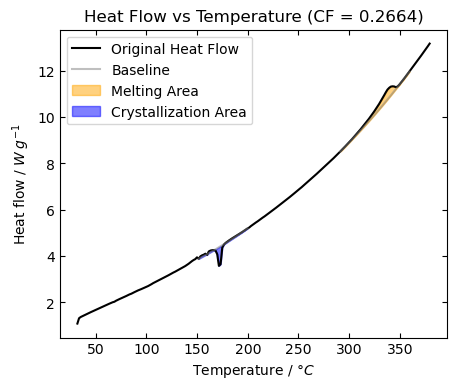

Sample: 500907_1, Cycle: 1.0, melt enthalpy: 34.6, CF: 0.2664 g/g


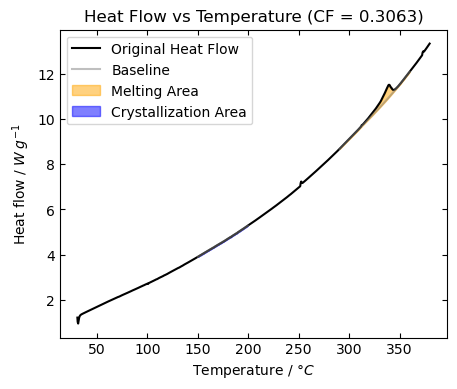

Sample: 500907_1, Cycle: 2.0, melt enthalpy: 39.8, CF: 0.3063 g/g


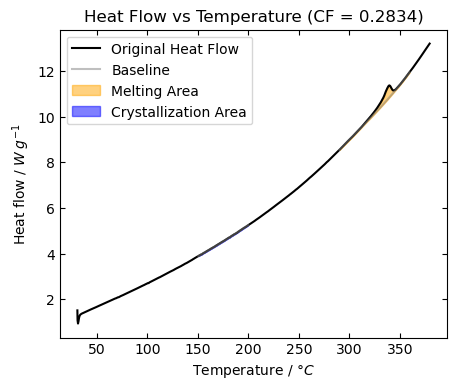

Sample: 500907_1, Cycle: 3.0, melt enthalpy: 36.8, CF: 0.2834 g/g


C:\Users\sieun\AppData\Local\Temp\ipykernel_13532\3469364541.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(baseline_points['T / °C'], baseline_points['q / W g^-1'], deg=3)
C:\Users\sieun\AppData\Local\Temp\ipykernel_13532\3469364541.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(baseline_points['T / °C'], baseline_points['q / W g^-1'], deg=3)


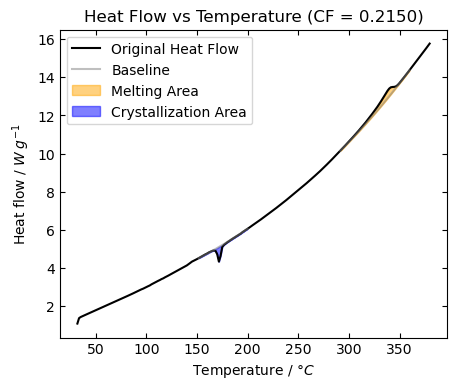

Sample: 500907_2, Cycle: 1.0, melt enthalpy: 28, CF: 0.2150 g/g


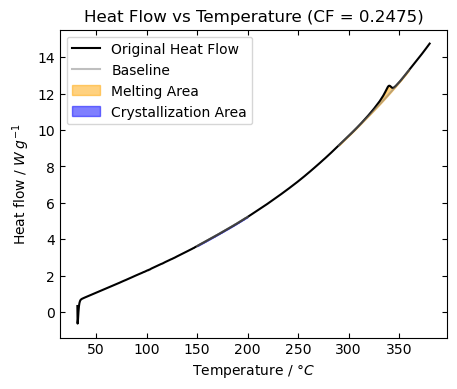

Sample: 500907_2, Cycle: 2.0, melt enthalpy: 32.2, CF: 0.2475 g/g


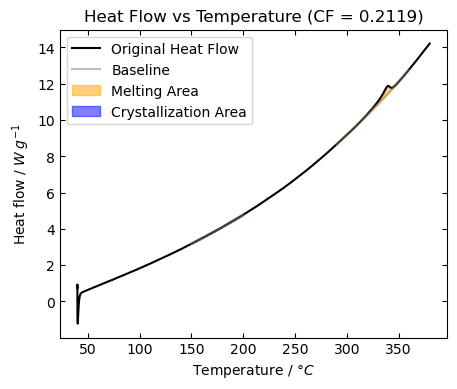

Sample: 500907_2, Cycle: 3.0, melt enthalpy: 27.6, CF: 0.2119 g/g


C:\Users\sieun\AppData\Local\Temp\ipykernel_13532\3469364541.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(baseline_points['T / °C'], baseline_points['q / W g^-1'], deg=3)
C:\Users\sieun\AppData\Local\Temp\ipykernel_13532\3469364541.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(baseline_points['T / °C'], baseline_points['q / W g^-1'], deg=3)


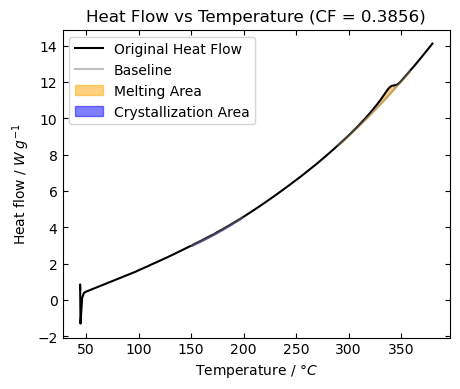

Sample: 501023_1, Cycle: 1.0, melt enthalpy: 50.1, CF: 0.3856 g/g


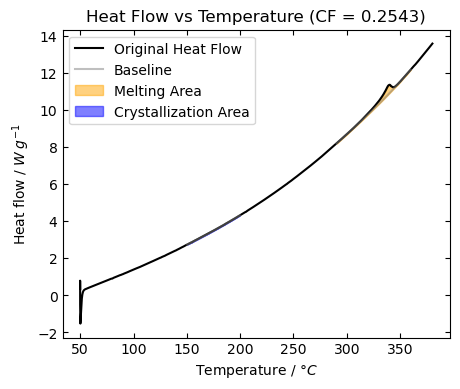

Sample: 501023_1, Cycle: 2.0, melt enthalpy: 33.1, CF: 0.2543 g/g


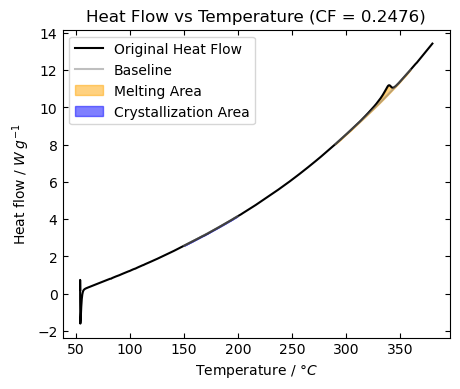

Sample: 501023_1, Cycle: 3.0, melt enthalpy: 32.2, CF: 0.2476 g/g


C:\Users\sieun\AppData\Local\Temp\ipykernel_13532\3469364541.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(baseline_points['T / °C'], baseline_points['q / W g^-1'], deg=3)
C:\Users\sieun\AppData\Local\Temp\ipykernel_13532\3469364541.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(baseline_points['T / °C'], baseline_points['q / W g^-1'], deg=3)


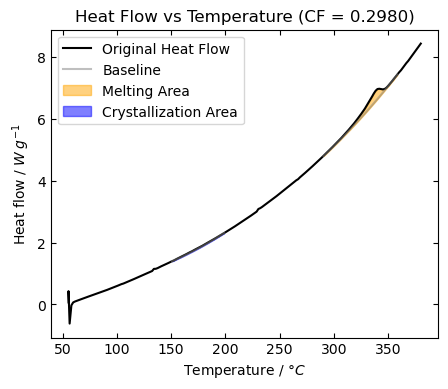

Sample: 501023_2, Cycle: 1.0, melt enthalpy: 38.7, CF: 0.2980 g/g


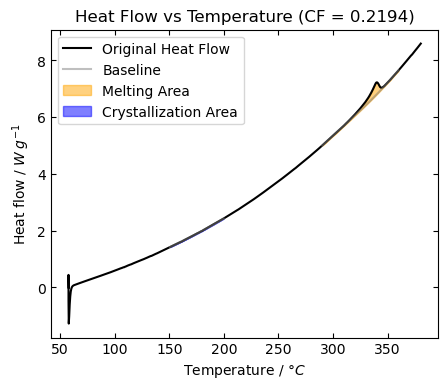

Sample: 501023_2, Cycle: 2.0, melt enthalpy: 28.5, CF: 0.2194 g/g


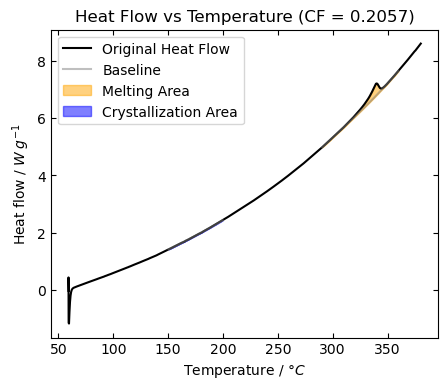

Sample: 501023_2, Cycle: 3.0, melt enthalpy: 26.7, CF: 0.2057 g/g


C:\Users\sieun\AppData\Local\Temp\ipykernel_13532\3469364541.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(baseline_points['T / °C'], baseline_points['q / W g^-1'], deg=3)
C:\Users\sieun\AppData\Local\Temp\ipykernel_13532\3469364541.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(baseline_points['T / °C'], baseline_points['q / W g^-1'], deg=3)


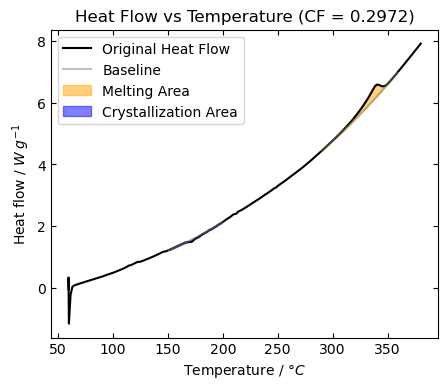

Sample: 501024_1, Cycle: 1.0, melt enthalpy: 38.6, CF: 0.2972 g/g


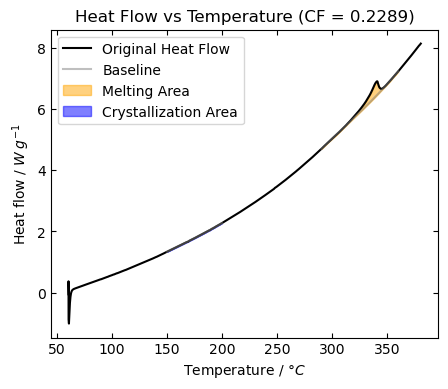

Sample: 501024_1, Cycle: 2.0, melt enthalpy: 29.8, CF: 0.2289 g/g


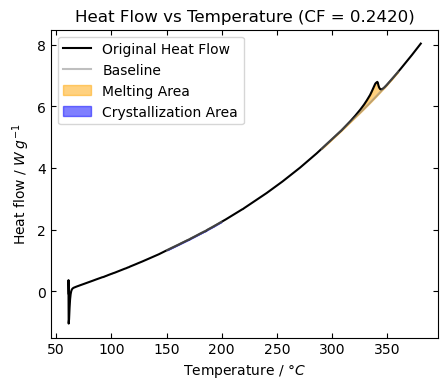

Sample: 501024_1, Cycle: 3.0, melt enthalpy: 31.5, CF: 0.2420 g/g


C:\Users\sieun\AppData\Local\Temp\ipykernel_13532\3469364541.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(baseline_points['T / °C'], baseline_points['q / W g^-1'], deg=3)


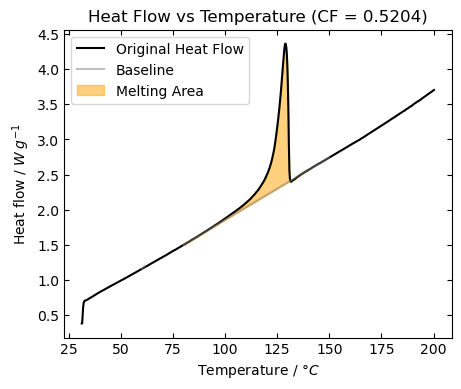

Sample: HDPE_1, Cycle: 1.0, melt enthalpy: 152, CF: 0.5204 g/g


C:\Users\sieun\AppData\Local\Temp\ipykernel_13532\3469364541.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(baseline_points['T / °C'], baseline_points['q / W g^-1'], deg=3)


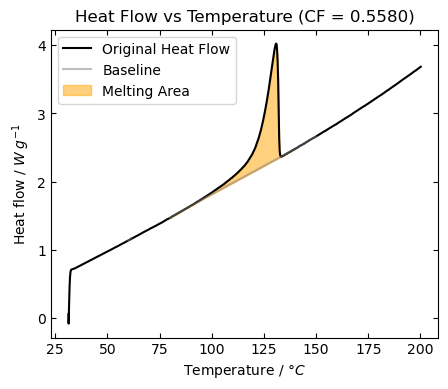

Sample: HDPE_1, Cycle: 2.0, melt enthalpy: 163, CF: 0.5580 g/g


C:\Users\sieun\AppData\Local\Temp\ipykernel_13532\3469364541.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(baseline_points['T / °C'], baseline_points['q / W g^-1'], deg=3)


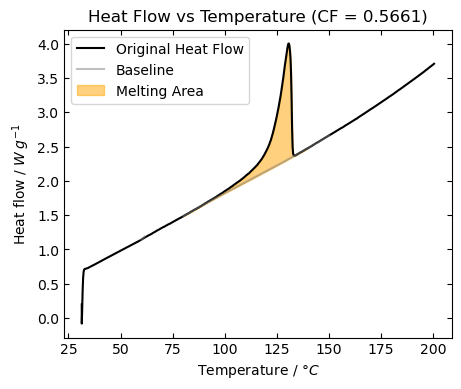

Sample: HDPE_1, Cycle: 3.0, melt enthalpy: 166, CF: 0.5661 g/g


C:\Users\sieun\AppData\Local\Temp\ipykernel_13532\3469364541.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(baseline_points['T / °C'], baseline_points['q / W g^-1'], deg=3)


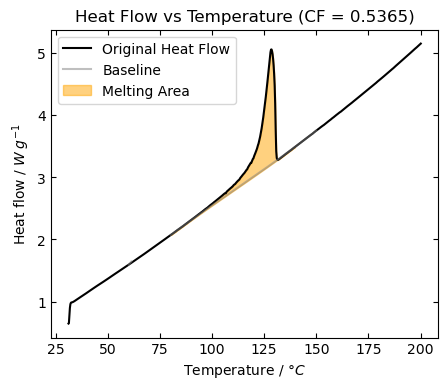

Sample: HDPE_2, Cycle: 1.0, melt enthalpy: 157, CF: 0.5365 g/g


C:\Users\sieun\AppData\Local\Temp\ipykernel_13532\3469364541.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(baseline_points['T / °C'], baseline_points['q / W g^-1'], deg=3)


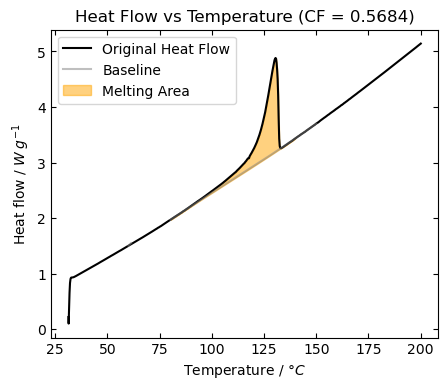

Sample: HDPE_2, Cycle: 2.0, melt enthalpy: 167, CF: 0.5684 g/g


C:\Users\sieun\AppData\Local\Temp\ipykernel_13532\3469364541.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(baseline_points['T / °C'], baseline_points['q / W g^-1'], deg=3)


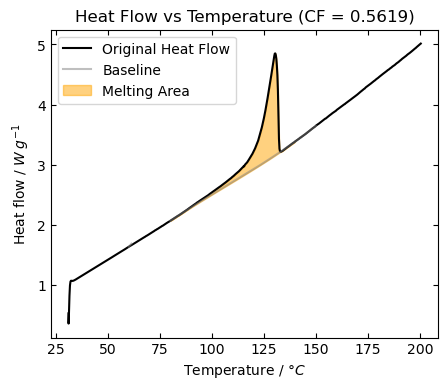

Sample: HDPE_2, Cycle: 3.0, melt enthalpy: 165, CF: 0.5619 g/g


In [39]:
# Create a new DataFrame to store the results
results_df = pd.DataFrame(columns=['sample', 'cycle', 
                                   'melt enthalpy / J g^-1', 
                                   'crystallisation enthalpy / J g^-1', 
                                   'net melt enthalpy / J g^-1', 
                                   'CF / g g^-1'])

heating_spectrum_df_dict = {}
for key, df in data_dict_heating.items():
    # if key in peek_samples:
    #     continue
    polymer = 'PEEK' if key in peek_samples else 'HDPE'
    
    for cycle_no in df['Cycle No'].unique():
        # Filter data for current cycle
        current_cycle_df = df[df['Cycle No'] == cycle_no].copy()
        
        # Calculate CF
        cf, net_melt_enthalpy, crys_enthalpy, melt_enthalpy, _df  = calculate_crystallisation_workflow(current_cycle_df, 
                                       baseline_low_temp_range_melt=low_temp_range_melt[polymer], 
                                       baseline_up_temp_range_melt=up_temp_range_melt[polymer], 
                                       baseline_low_temp_range_crys=low_temp_range_crys[polymer], 
                                       baseline_up_temp_range_crys=up_temp_range_crys[polymer], 
                                       int_temp_range_melt=temp_range_melt[polymer], 
                                       int_temp_range_crys=temp_range_crys[polymer], 
                                       melt_enthalpy_crys=melt_enthalpy_cr[polymer],
                                       plot=True)
        
        new_row = {'sample': key, 
                   'cycle': cycle_no, 
                   'CF / g g^-1': cf, 
                   'crystallisation enthalpy / J g^-1': crys_enthalpy,
                   'melt enthalpy / J g^-1': melt_enthalpy, 
                   'net melt enthalpy / J g^-1': net_melt_enthalpy
                   }
        results_df.loc[len(results_df)] = new_row
        print(f"Sample: {key}, Cycle: {cycle_no}, melt enthalpy: {net_melt_enthalpy:.3g}, CF: {cf:.4f} g/g")
        
        # Save the heating spectrum DataFrame for each sample and cycle
        heating_spectrum_df_dict[f'{key}_cycle{cycle_no:.0f}'] = _df

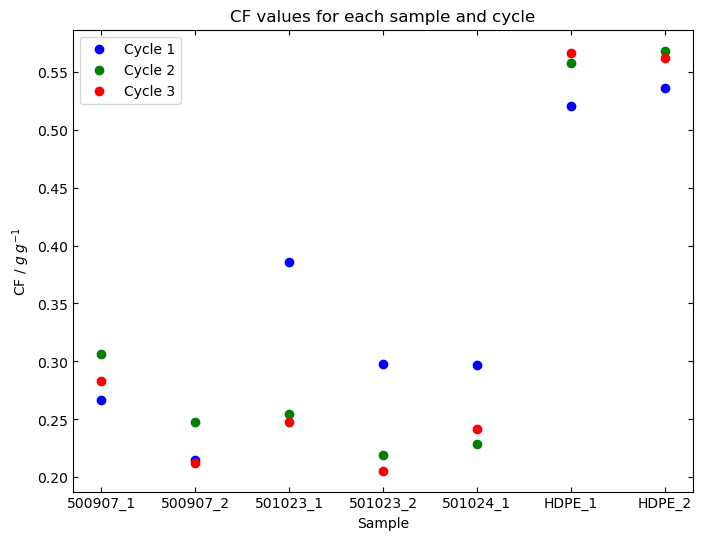

In [ ]:
# Plot the CF values
plt.figure(figsize=(8, 6))

# Define colors for each cycle number
colors = {1: 'b', 2: 'g', 3: 'r'}

# Plot CF values for each cycle with different colors
for cycle_no in results_df['cycle'].unique():
    cycle_df = results_df[results_df['cycle'] == cycle_no]
    plt.scatter(cycle_df['sample'], cycle_df['CF / g g^-1'], 
                marker='o', color=colors[int(cycle_no)], label=f'Cycle {int(cycle_no)}')

plt.xlabel('Sample')
plt.ylabel(r'CF / $g \; g^{-1}$')
plt.title('CF values for each sample and cycle')
# plt.ylim(0.12, 0.3)
plt.legend()
plt.tick_params(direction='in', top=True, right=True)
plt.show()

Exporting.

In [42]:
# Export results DataFrame to Excel
import os
import pandas as pd

"""
Export all DSC results to a single Excel file with multiple tabs
"""
# Create results directory if it doesn't exist
results_dir = "../results"
os.makedirs(results_dir, exist_ok=True)

# Create Excel file path with timestamp
excel_filename = os.path.join(results_dir, f"DSC_results.xlsx")

# Create Excel writer object
with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
    # Write the results DataFrame to the first sheet
    results_df.to_excel(writer, sheet_name='Overview', index=False)
    
    # Write each heating spectrum DataFrame to a separate sheet
    for sheet_name, heating_df in heating_spectrum_df_dict.items():
        heating_df.to_excel(writer, sheet_name=sheet_name, index=False)


Plotting the exported data.

In [ ]:
def plot_dsc_from_excel(excel_file_path, sample_name, 
                       melting_range=None, crystallization_range=None,
                       figsize=(5, 4)):
    """
    Read exported Excel file and plot DSC data in the same style as the original workflow.
    
    Parameters:
    -----------
    excel_file_path : str
        Path to the Excel file containing DSC analysis results
    sample_name : str
        Sample name/filename without extension (e.g., '501023_1')
    melting_range : tuple, optional
        Temperature range for melting region (min_temp, max_temp)
    crystallization_range : tuple, optional
        Temperature range for crystallization region (min_temp, max_temp)
    figsize : tuple, optional
        Figure size for the plot (width, height)
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    import os
    
    # Load the overview tab to get sample information
    overview_df = pd.read_excel(excel_file_path, sheet_name='Overview')
    sample_row = overview_df[overview_df['Filename'].str.contains(sample_name, case=False, na=False)]
    
    if sample_row.empty:
        available_samples = overview_df['Filename'].tolist()
        raise ValueError(f"Sample '{sample_name}' not found. Available: {available_samples}")
    
    sample_info = sample_row.iloc[0]
    
    # Create tab name
    tab_name = os.path.splitext(sample_info['Filename'])[0]
    if len(tab_name) > 31:
        tab_name = tab_name[:31]
    
    # Load DSC data
    dsc_df = pd.read_excel(excel_file_path, sheet_name=tab_name)
    
    # Find temperature and heat flow columns
    temp_col = 'T / °C'
    heat_flow_col = 'q / W g^-1'
    baseline_col = 'q_bl / W g^-1'
    
    if temp_col not in dsc_df.columns:
        raise ValueError(f"Temperature column '{temp_col}' not found in the data.")
    if heat_flow_col not in dsc_df.columns:
        raise ValueError(f"Heat flow column '{heat_flow_col}' not found in the data.")
    if baseline_col not in dsc_df.columns:
        raise ValueError(f"Baseline column '{baseline_col}' not found in the data.")
    
    # Get data
    temperature = dsc_df[temp_col].values
    heat_flow = dsc_df[heat_flow_col].values
    baseline = dsc_df[baseline_col].values
    
    # Create the plot
    plt.figure(figsize=figsize)
    
    # Plot original heat flow
    plt.plot(temperature, heat_flow, 
            color='black', 
            label='Original Heat Flow')
    
    # Plot baseline
    plt.plot(temperature, baseline, 
            color='gray', 
            alpha=0.5, 
            label='Baseline')
    
    # Shade melting area if range provided
    if melting_range is not None:
        melt_mask = (temperature >= melting_range[0]) & (temperature <= melting_range[1])
        if np.any(melt_mask):
            plt.fill_between(temperature[melt_mask], 
                            baseline[melt_mask], 
                            heat_flow[melt_mask], 
                            alpha=0.5, color='orange', label='Melting Area')
    
    # Shade crystallization area if range provided
    if crystallization_range is not None:
        crys_mask = (temperature >= crystallization_range[0]) & (temperature <= crystallization_range[1])
        if np.any(crys_mask):
            plt.fill_between(temperature[crys_mask], 
                            baseline[crys_mask], 
                            heat_flow[crys_mask], 
                            alpha=0.5, color='blue', label='Crystallization Area')
    
    plt.xlabel(r'Temperature / $°C$')
    plt.ylabel(r'Heat flow / $W \; g^{-1}$')
    plt.title(f'Heat Flow vs Temperature (CF = {cf:.4f})')
    plt.legend()
    plt.tick_params(direction='in', top=True, right=True)
    plt.show()


# Usage
temp_range_melt = {'PEEK': (290, 360), 'HDPE': (80, 140)}    # [°C]
temp_range_crys = {'PEEK': (150, 200), 'HDPE': (50, 50.00001)}    # [°C]
polymer = 'PEEK'  # or 'HDPE'

plot_dsc_from_excel(excel_file_path='../data/DSC_results.xlsx', 
                   sample_name='501023_1', 
                   melting_range=temp_range_melt[polymer], 
                   crystallization_range=temp_range_crys[polymer],
                   figsize=(5, 4))
